# Bayesian Network for the Grades of Portuguese Students
This notebook contains the code for the Bayesian Network calculating the grades of Portuguese students. The Bayesian Network is based on the analysis of the data from the *analyse-data.ipynb* notebook. The Bayesian Network is implemented using the *pgmpy* library and the train data is loaded from the *student-por_2.csv* file in the data folder.

## 0. Install required libraries
This section installs all needed libraries in a python virtual environment which can be used as Jupyter kernel. This needs only to be done once.

In [1]:
%%python -m venv ../.env
%%source ../.env/bin/activate
%pip install -r ../requirements.txt

## 1. Import libraries
This section imports all needed libraries and sets the path to the data, number of rows to be displayed.

In [2]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from sklearn.model_selection import train_test_split

# Self-written modules for better code structure
from framework import Framework
from evaluation import Evaluation

# Set matplotlib options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set pandas options
pd.set_option('display.max_columns', 500)

# Constants
DATA_PATH = "../data/"
DOC_PATH = "../doc/"
RANDOM_STATE = 12
NUMBER_CORES = 10 # !IMPORTAN: Set this to the number of cores of your machine for parallelization. It is recommended to use not all cores.

## 2. Load and prepare data
For the Bayesian Network we need to load the data from the *student-por_2.csv* file. The data is loaded using the *pandas* library. The data is prepared for the training by the following steps:

1. Delete the column *Unnamed: 33* which contains not explained data.

In [3]:
def prepare_data(data: pd.DataFrame, *args) -> pd.DataFrame:
    """Converts the data to a format that can be used for training and drops not needed columns.

    Args:
        data (pd.DataFrame): The data to be prepared.
        args (list): The additional columns to be dropped.
        
    Returns:
        pd.DataFrame: The prepared data.
    """
    for column in [*args, 'Unnamed: 33']:
        del data[column]
    return data
    

train_data = pd.read_csv(DATA_PATH + "student-por_2.csv", sep=";")
train_data = train_data.drop(train_data[train_data['G3'] == 0].index)
train_data = train_data.drop(train_data[train_data['G3'] == 1].index)
test_data = train_data.copy()
# train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=RANDOM_STATE)

train_data = prepare_data(train_data)
labels = test_data.loc[:, 'G3']
test_data = prepare_data(test_data, 'G3', 'G1', 'age', 'school')

## 3. Create Bayesian Network
The Bayesian Network is created using the *pgmpy* library. For this we need to define the structure of nodes and edges of the network. After the analysis of the data in the *analyse-data.ipynb* notebook we came up with the following structure:

TODO: Add structure

First we define the structure of the network and then we add the conditional probability tables (CPT) to the nodes by "training" the network with the train data.

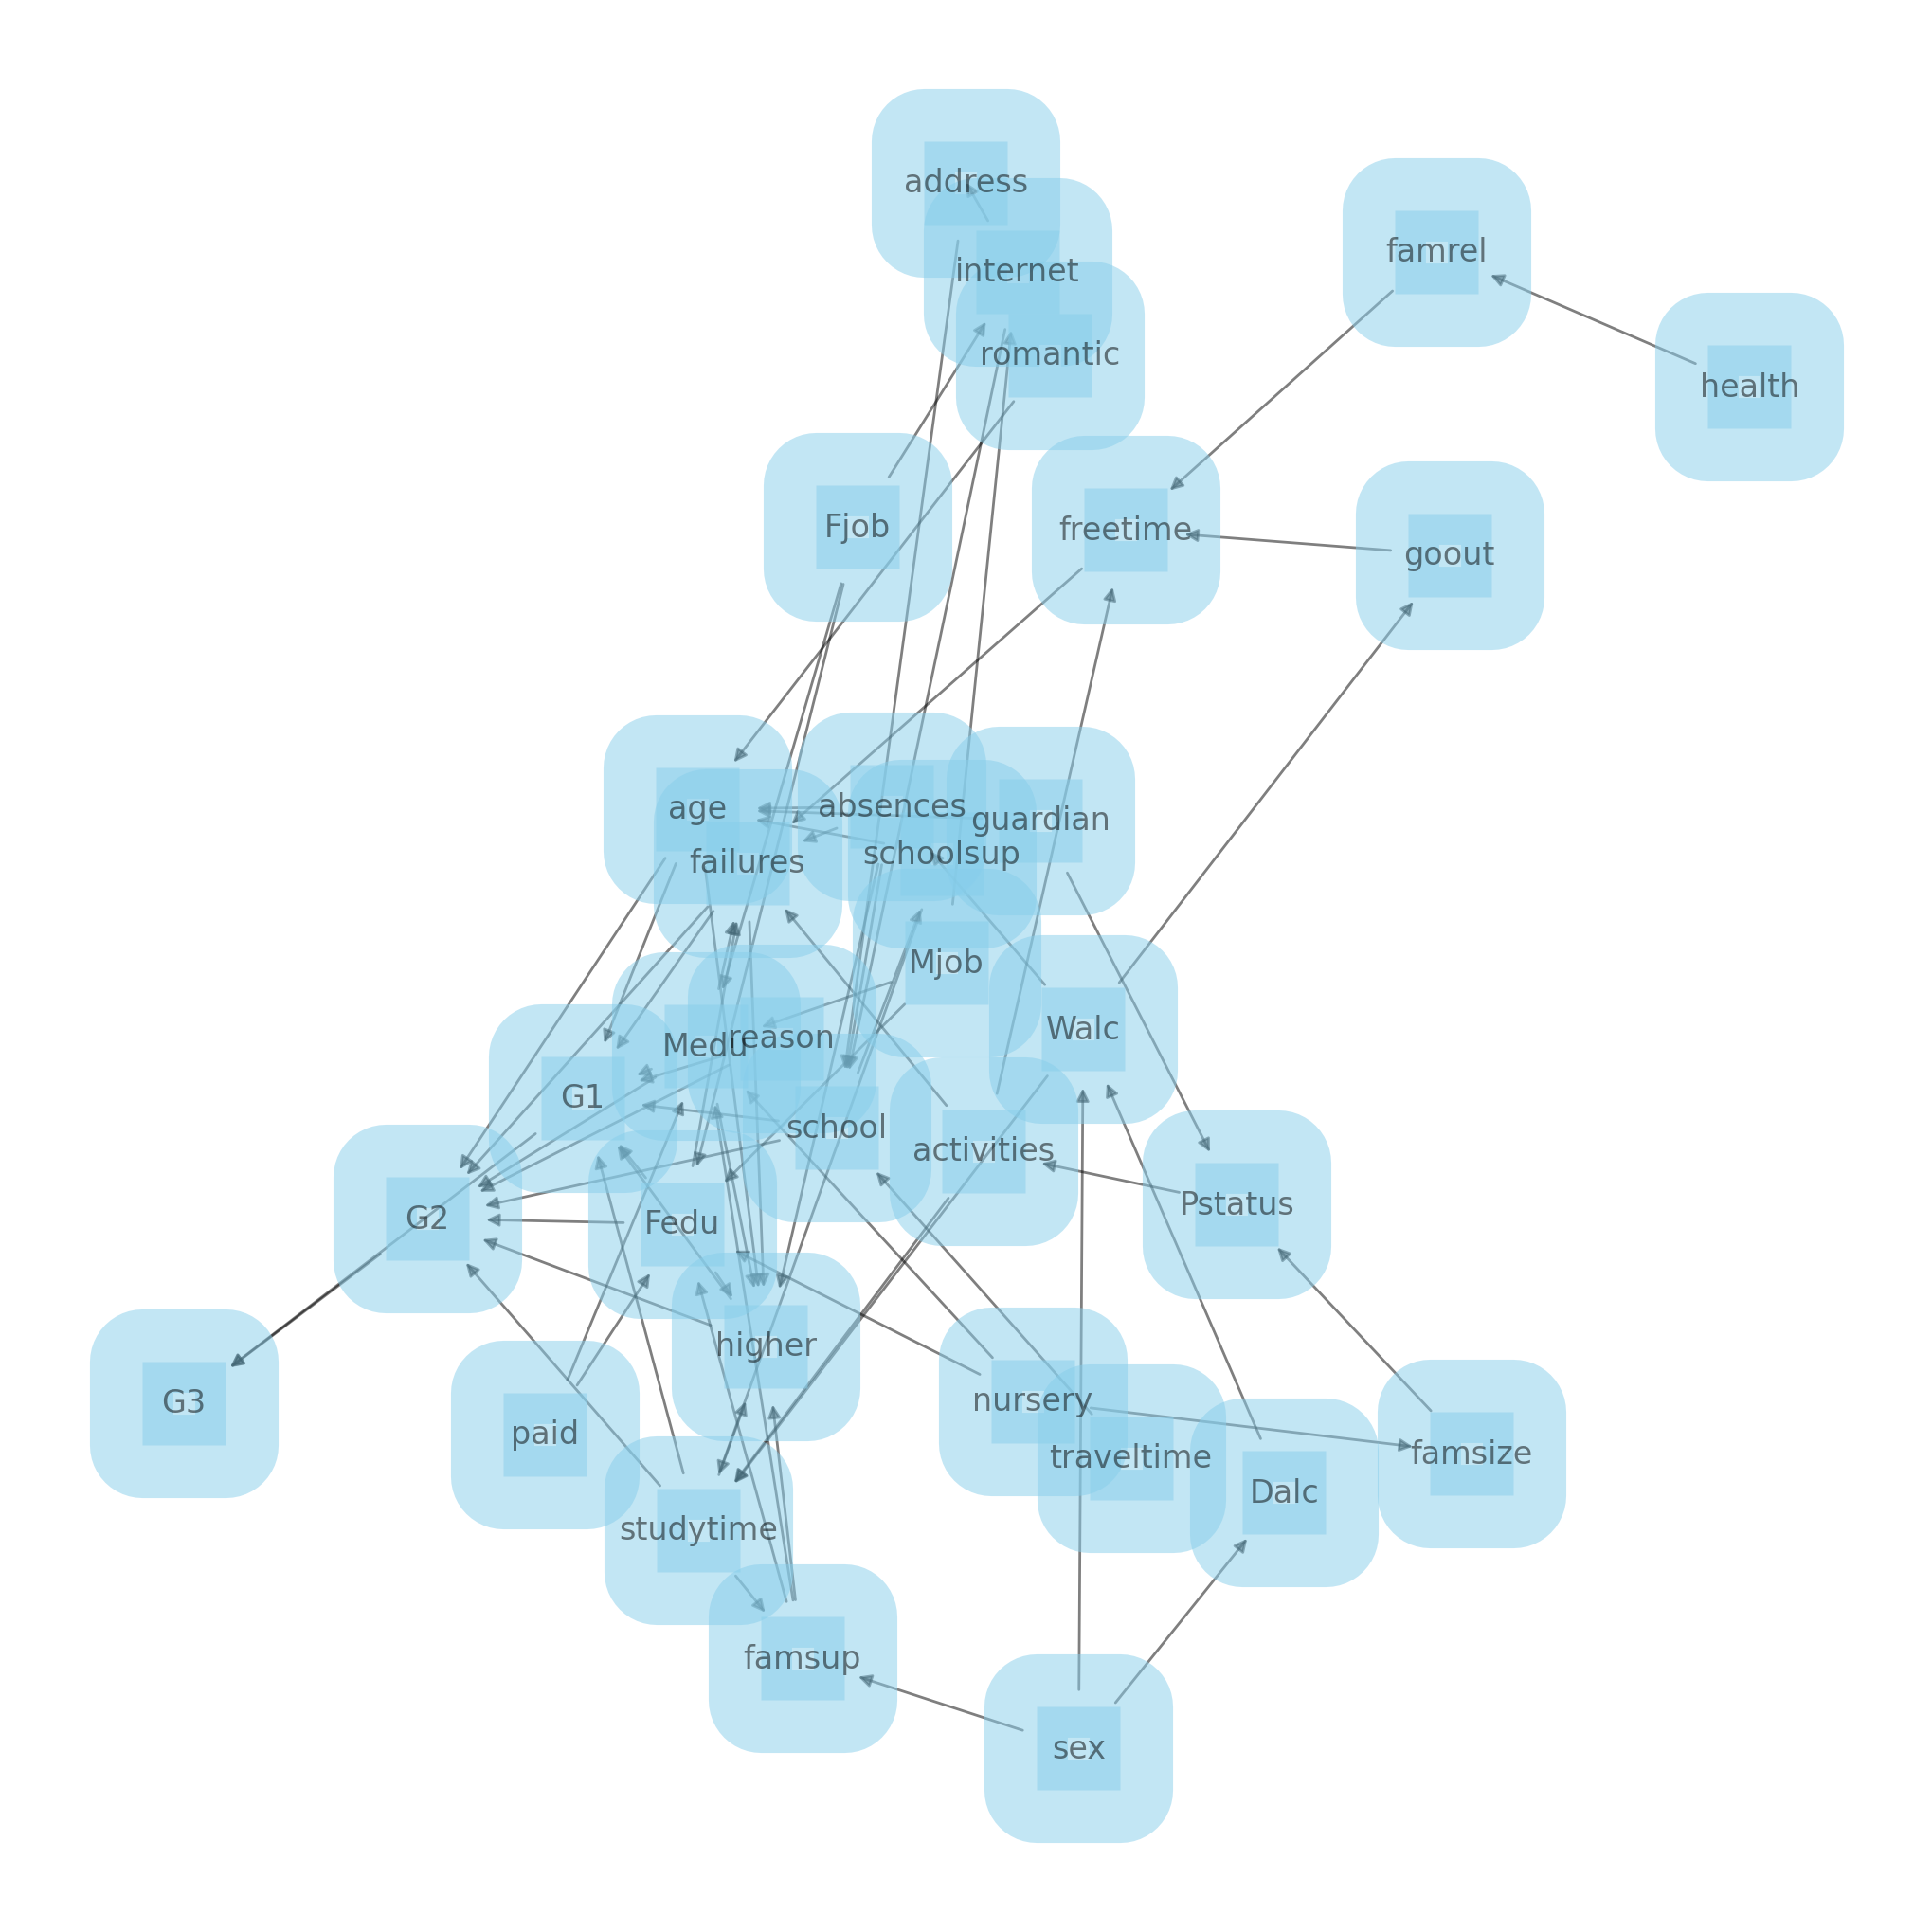

In [4]:
# Create Network
network = BayesianNetwork()

# Add all columns as nodes
for col in train_data.columns:
    network.add_node(col)
    
# Add edges
edges = [
    # Grades
    # ('G1', 'G2'),
    ('G1', 'G3'),
    ('G2', 'G3'),
    
    # To G1 and G2
    ('reason', 'G1'),
    ('Medu', 'G1'),
    ('Fedu', 'G1'),
    ('school', 'G1'),
    ('failures', 'G1'),
    ('higher', 'G1'),
    ('age', 'G1'),
    ('studytime', 'G1'),
    ('reason', 'G2'),
    ('Medu', 'G2'),
    ('Fedu', 'G2'),
    ('school', 'G2'),
    ('failures', 'G2'),
    ('higher', 'G2'),
    ('age', 'G2'),
    ('studytime', 'G2'),
    
    # Medu and Fedu
    ('Mjob', 'Medu'),
    ('Fjob', 'Fedu'),
    ('Mjob', 'Fedu'),
    ('Fjob', 'Medu'),
    ('Mjob', 'internet'),
    ('Fjob', 'internet'),
    ('famsup', 'Fedu'),
    ('famsup', 'Medu'),
    ('Medu', 'failures'),
    ('Fedu', 'failures'),
    ('Medu', 'higher'),
    ('Fedu', 'higher'),
    ('paid', 'Medu'),
    ('paid', 'Fedu'),
    ('nursery', 'Medu'),
    ('nursery', 'Fedu'),
    
    # Family
    ('nursery', 'famsize'),
    ('famsize', 'Pstatus'),
    ('guardian', 'Pstatus'),
    ('health', 'famrel'),
    ('famrel', 'freetime'),
    ('sex', 'famsup'),
    ('famsup', 'higher'),
    ('studytime', 'famsup'),
    
    
    # Free time
    ('sex', 'Dalc'),
    ('sex', 'Walc'),
    ('Dalc', 'Walc'),
    ('Walc', 'goout'),
    ('goout', 'freetime'),
    ('Pstatus', 'activities'),
    ('activities', 'freetime'),
    ('activities', 'failures'),
    ('freetime', 'failures'),
    ('Walc', 'absences'),
    ('activities', 'studytime'),
    ('Walc', 'studytime'),
    ('absences', 'failures'),
    ('absences', 'school'),
    ('absences', 'higher'),
    ('absences', 'age'),
    
    # School
    ('internet', 'address'),
    ('internet', 'school'),
    ('address', 'school'),
    ('traveltime', 'school'),
    ('school', 'schoolsup'),
    ('schoolsup', 'age'),
    ('schoolsup', 'studytime'),
    
    # Rest
    ('failures', 'higher'),
    ('age', 'higher'),
    ('romantic', 'age'),
    ('guardian', 'age'),
    ('studytime', 'higher',),
    
]

# Add edges to network and draw it
Framework.add_edges(network, edges)
Framework.draw_model(network) # TODO: THIS IS NOT WORKING



In [5]:
# from pgmpy.estimators import PC

# est = PC(train_data)
# skel, seperating_sets = est.build_skeleton(significance_level=0.10, n_jobs=NUMBER_CORES)
# print("Undirected edges: ", skel.edges())

# pdag = est.skeleton_to_pdag(skel, seperating_sets)
# print("PDAG edges:       ", pdag.edges())

# model = pdag.to_dag()
# print("DAG edges:        ", model.edges())



In [6]:
# Fit data
network.fit(train_data, n_jobs=NUMBER_CORES)

## 3. Test Bayesian Network and evaluate results
The Bayesian Network is tested with the test data loaded in step 2. The prepared test data is used to predict the grades of the students. The results are evaluated by comparing the predicted grades with the actual grades. The evaluation is done by calculating the accuracy of the predictions and a plot of the false positive, false negative predictions, true positive and true negative predictions.


In [7]:
# Create predictions
predictions = network.predict(test_data, stochastic=False, n_jobs=NUMBER_CORES)

# Save results for later evaluation
predictions.to_csv(DATA_PATH + "results.csv", index=False)
labels.to_csv(DATA_PATH + "label.csv", index=False)

  0%|          | 0/583 [00:00<?, ?it/s]

/home/tom/projects/probability-ki/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5523156089193825
Mean false error: 1.260536398467433
Mean absolute error: 0.5643224699828473
Precision: 0.5764733228214606
Recall: 0.47142663638098087
F1 score: 0.4914991592179166


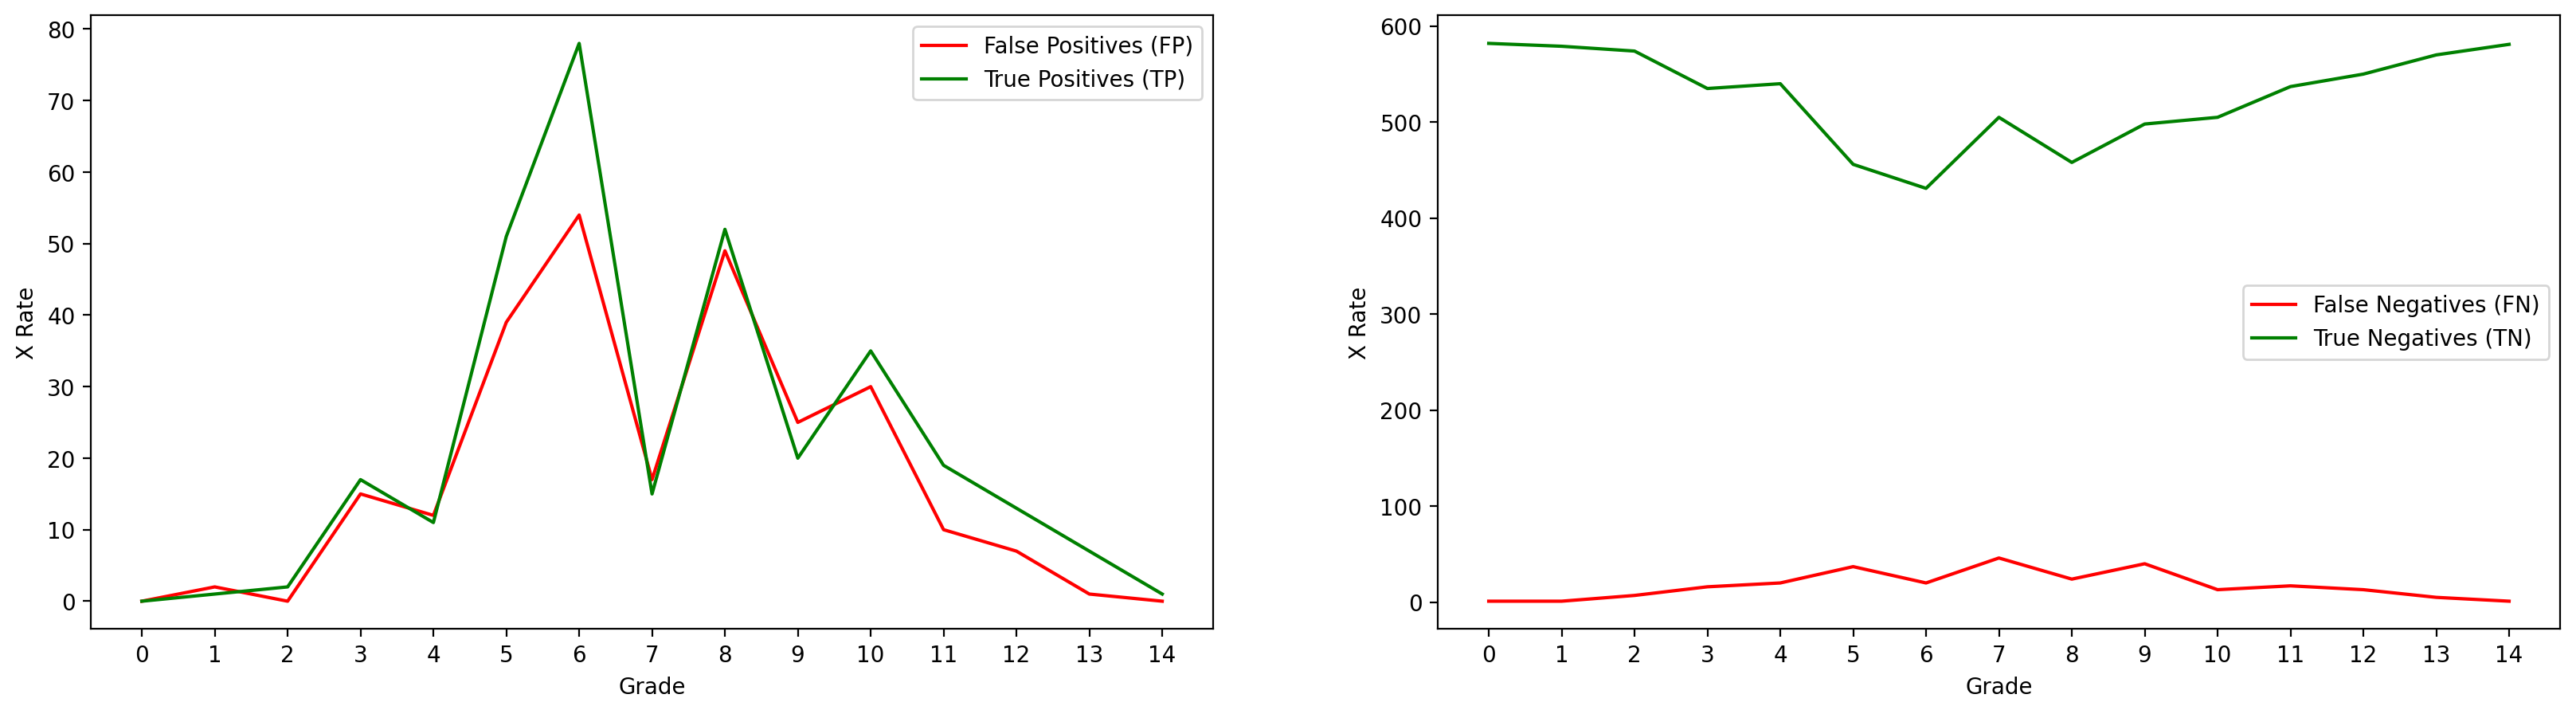

In [8]:
predictions = pd.read_csv(DATA_PATH + "results.csv")
labels = pd.read_csv(DATA_PATH + "label.csv")

# Evaluate results
evaluation = Evaluation(labels['G3'], predictions.loc[:, 'G3'])
evaluation.print_stats()
evaluation.plot()